# Tutorial: Integrating GWAS with Single-Cell Data using cellink
This tutorial demonstrates how to integrate GWAS (Genome-Wide Association Studies) data with single-cell genomics using [`scDRS`](https://www.nature.com/articles/s41588-022-01167-z) and [`Seismic`](https://www.nature.com/articles/s41467-025-63753-z) through the cellink package. `scDRS` identifies disease-relevant invididual cells, tests for heterogeneity within cell types and cell-level disease associations and correlates disease scores with cell-level variables. `Seismic` links cell types with traits and identifies influential genes driving associations. Both scDRS and seismic benefit from larger sample sizes. Aim for >50 donors and well-powered GWAS for robust results. The results depend on cell type granularity. Consider running analyses at multiple resolutions.

We also demonstrate how to identify relevant gene sets using MAGMA. Both tools work seamlessly with `cellink's` DonorData structure. To use `scDRS` please install cellink via pip install `'cellink[scdrs]'`. To use `Seismic` please install it via: `R -e "devtools::install_github('ylaboratory/seismicGWAS')"` and additionally install `rpy2` via: `pip install rpy2`.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numba
numba.set_num_threads(1)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
import scanpy as sc

from cellink.resources import get_dummy_onek1k, get_gwas_catalog_study_summary_stats
from cellink.tl.external import run_scdrs, run_seismic, run_magma_pipeline

dd = get_dummy_onek1k(
    config_path="../../src/cellink/resources/config/dummy_onek1k.yaml",
    verify_checksum=False
)
dd.G.obs["donor_id"] = dd.G.obs.index

print(f"Dataset shape: {dd.shape}")
print(f"Cell types: {dd.C.obs['predicted.celltype.l2'].unique()[:5]}")

[2026-01-14 19:11:20,541] INFO:root: /Users/larnoldt/cellink_data/dummy_onek1k/dummy_onek1k.dd.h5 already exists
[2026-01-14 19:11:20,541] WARNING:root: No checksum provided, skipping verification
[2026-01-14 19:11:21,651] INFO:root: Loaded dummy OneK1K dataset: (100, 146939, 125366, 34073)
Dataset shape: (100, 146939, 125366, 34073)
Cell types: ['gdT', 'NK', 'CD8 TEM', 'CD4 Naive', 'CD4 TCM']
Categories (31, object): ['ASDC', 'B intermediate', 'B memory', 'B naive', ..., 'cDC2', 'dnT', 'gdT', 'pDC']


We filter the DonorData object to speed-up the computation for demonstration purposes.

In [2]:
celltype_counts = dd.C.obs["predicted.celltype.l2"].value_counts()
celltypes_of_interest = celltype_counts[celltype_counts > 100].index
dd.C = dd.C[
    dd.C.obs["predicted.celltype.l2"].isin(celltypes_of_interest)
].copy()
dd.C = dd.C[:, dd.C.var["vst.variable"] == 1].copy()

We utilize a publicly available GWAS summary statistic, here for iunstance for Type 2 Diabetes.

In [3]:
gwas_df = get_gwas_catalog_study_summary_stats("GCST90018926", genome_build="GRCh37")
gwas_df

[2026-01-14 19:11:23,064] INFO:root: Fetching https://www.ebi.ac.uk/gwas/rest/api/v2/studies/GCST90018926
[2026-01-14 19:11:23,258] INFO:root: User requested GRCh37, skipping harmonised files and searching base directory
[2026-01-14 19:11:23,343] INFO:root: Selected file matching requested build GRCh37: GCST90018926_buildGRCh37.tsv.gz
[2026-01-14 19:11:23,344] INFO:root: Using build-specific summary statistics (build: GRCh37)
[2026-01-14 19:11:23,346] INFO:root: Downloading http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST90018001-GCST90019000/GCST90018926/GCST90018926_buildGRCh37.tsv.gz to /Users/larnoldt/cellink_data/GCST90018926_summary_stats.tsv.gz


/Users/larnoldt/sc-genetics/src/cellink/resources/_gwas_prs_qtl.py:428: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dest, compression="gzip", delimiter="\t")


,chromosome,base_pair_location,effect_allele,other_allele,effect_allele_frequency,beta,standard_error,p_value,variant_id
0,1,100000012,T,G,0.280989,-0.0146,0.0068,0.03234,NaN
1,1,10000006,A,G,0.005652,0.0336,0.0561,0.54980,NaN
2,1,100000135,T,A,0.001687,-0.0276,0.1122,0.80540,NaN
3,1,100000374,C,G,0.000579,0.2396,0.1991,0.22880,NaN
4,1,100000827,T,C,0.332151,-0.0148,0.0065,0.02345,NaN
...,...,...,...,...,...,...,...,...,...
25845086,X,99998829,T,C,0.439544,-0.0103,0.0050,0.03884,NaN
25845087,X,99999212,CT,C,0.542889,0.0157,0.0087,0.07114,NaN
25845088,X,99999349,A,G,0.551784,0.0102,0.0050,0.03944,NaN
25845089,X,9999977,A,G,0.001073,-0.3525,0.1717,0.04007,NaN


We convert the public GWAS statistic to gene-level statistics using MAGMA. MAGMA needs to be downloaded as shown below:

In [4]:
import requests, zipfile, io, os, stat

url = "https://vu.data.surf.nl/public.php/dav/files/1M1d9vHtVidEwvU/?accept=zip"

r = requests.get(url)
r.raise_for_status() 

with zipfile.ZipFile(io.BytesIO(r.content)) as z:
    z.extractall("magma")

for root, dirs, files in os.walk("magma"):
    for file in files:
        path = os.path.join(root, file)
        st = os.stat(path)
        os.chmod(path, st.st_mode | stat.S_IEXEC) 

In [5]:
custom_mapping = {
    "chromosome": "CHR",
    "base_pair_location": "BP",
    "p_value": "P",
}

magma_file = run_magma_pipeline(dd, gwas_df, output_prefix="trait", col_mapping=custom_mapping, n_samples=667504, magma_bin="./magma/magma", genome_build="GRCh37", gene_id_type="ensembl", config_file="../../configs/magma.yaml")

[2026-01-14 19:11:59,920] INFO:cellink.tl.external._magma: Starting MAGMA pipeline
[2026-01-14 19:11:59,921] INFO:cellink.tl.external._magma: Preparing MAGMA input files from DonorData
[2026-01-14 19:11:59,921] INFO:cellink.tl.external._magma: Downloading/checking gene location file
[2026-01-14 19:11:59,925] INFO:cellink.tl.external._magma: Using cached gene location file: /Users/larnoldt/cellink_data/magma_references/NCBI37.3.gene.loc
[2026-01-14 19:11:59,925] INFO:cellink.tl.external._magma: Using cached converted gene location file: /Users/larnoldt/cellink_data/magma_references/GRCh37_ensembl.gene.loc
[2026-01-14 19:11:59,926] INFO:cellink.tl.external._magma: Preparing SNP location and p-value files
[2026-01-14 19:12:32,520] INFO:cellink.tl.external._magma: Created SNP location file: trait.snp_loc.txt
[2026-01-14 19:12:49,809] INFO:cellink.tl.external._magma: Created p-value file: trait.p_val.txt
[2026-01-14 19:12:49,810] INFO:cellink.tl.external._magma: Exporting genotypes to PLINK

Writing BED: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

Writing FAM... done.
Writing BIM... 

done.
[2026-01-14 19:12:50,437] INFO:cellink.tl.external._magma: Created PLINK files: trait_ld_ref.{bed,bim,fam}
[2026-01-14 19:12:50,789] INFO:cellink.tl.external._magma: Running MAGMA SNP annotation
[2026-01-14 19:12:50,789] INFO:cellink.tl.external._magma: Running: ./magma/magma --annotate window=35,10 --snp-loc trait.snp_loc.txt --gene-loc /Users/larnoldt/cellink_data/magma_references/GRCh37_ensembl.gene.loc --out trait
[2026-01-14 19:13:21,381] INFO:cellink.tl.external._magma: Welcome to MAGMA v1.10 (custom)
Using flags:
	--annotate window=35,10
	--snp-loc trait.snp_loc.txt
	--gene-loc /Users/larnoldt/cellink_data/magma_references/GRCh37_ensembl.gene.loc
	--out trait

Start time is 19:12:52, Wednesday 14 Jan 2026

Starting annotation...
Reading gene locations from file /Users/larnoldt/cellink_data/magma_references/GRCh37_ensembl.gene.loc... 
	adding window: 35000bp (before), 10000bp (after)
	20134 gene locations read from file
	chromosome  1: 1964 genes
	chromosome  2: 1154 genes


## Part 1: scDRS Analysis - Cell-Level Disease Associations
scDRS identifies individual cells with excess expression of disease-associated genes and performs downstream analyses at the cell group level.

In [6]:
magma_results = pd.read_csv("trait.genes.out", sep=r'\s+')

top_genes = magma_results.nsmallest(1000, 'P')['GENE'].tolist()
gene_weights = magma_results.nsmallest(1000, 'P')['ZSTAT'].tolist()

gene_sets = {
    "Type2Diabetes": (top_genes, gene_weights)
}

### Running scDRS

In [7]:
results_scdrs, downstream_results = run_scdrs(
    dd.C,
    gene_sets=gene_sets,
    group_analysis=["predicted.celltype.l2"],  # Cell type column
    corr_analysis=["n_genes"],  # Cell-level variables
    gene_analysis=True,
    n_ctrl=1000,
    prefix="t2d_scdrs",
    save_results=True,
)

score_df = results_scdrs["Type2Diabetes"]
print(f"Computed scores for {len(score_df)} cells")
print(score_df.head())

ct_results = downstream_results["Type2Diabetes"]["group_predicted.celltype.l2"]
print("\nTop cell type associations:")
print(ct_results.sort_values("assoc_mcp").head())

[2026-01-14 19:13:32,590] INFO:cellink.tl.external._scdrs: Filtering cells and genes
[2026-01-14 19:13:32,947] INFO:cellink.tl.external._scdrs: Log-normalizing data


/opt/miniconda3/envs/single_cell_base3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


[2026-01-14 19:13:32,967] INFO:cellink.tl.external._scdrs: Preprocessing data for scDRS
Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=15
[2026-01-14 19:13:34,440] INFO:cellink.tl.external._scdrs: Computing scDRS scores for 1 trait(s)
[2026-01-14 19:13:34,447] INFO:cellink.tl.external._scdrs: Processing Type2Diabetes


Computing control scores: 100%|██████████| 1000/1000 [00:24<00:00, 40.70it/s]


[2026-01-14 19:14:21,638] INFO:cellink.tl.external._scdrs: Computing KNN graph for heterogeneity analysis
[2026-01-14 19:14:54,044] INFO:cellink.tl.external._scdrs: Performing group analysis for Type2Diabetes


/opt/miniconda3/envs/single_cell_base3/lib/python3.12/site-packages/scdrs/method.py:957: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, df_group in df_meta.groupby(groupby):


[2026-01-14 19:15:41,759] INFO:cellink.tl.external._scdrs: Performing correlation analysis for Type2Diabetes
[2026-01-14 19:15:41,868] INFO:cellink.tl.external._scdrs: Performing gene analysis for Type2Diabetes
Computed scores for 12796 cells
                     raw_score  norm_score   mc_pval      pval  nlog10_pval  \
barcode                                                                       
CGTGTCTGTGTAAGTA-15  -0.624232   -1.889532  0.983017  0.980244     0.008666   
AGCTCTCAGGCTCATT-15   0.130947   -0.153074  0.451548  0.510812     0.291739   
CCTTACGGTTGGAGGT-15   0.667973    0.250309  0.308691  0.329169     0.482582   
TCAGATGCACACGCTG-15  -0.143528   -0.887485  0.856144  0.858069     0.066478   
CTTGGCTCAGTTTACG-15   0.788558    1.176018  0.119880  0.116356     0.934213   

                       zscore  ctrl_norm_score_0  ctrl_norm_score_1  \
barcode                                                               
CGTGTCTGTGTAAGTA-15 -2.058819           0.267834           0.

### Visualizing scDRS Results

We first visualize the distribution of the Norm socres and the cell types. Also we then plot the statistic to identify disease-relevant cell populations. Please note, that this is a dummy OneK1K dataset. 

[2026-01-14 19:15:41,947] INFO:cellink.tl.external._scdrs: Filtering cells and genes
[2026-01-14 19:15:42,025] INFO:cellink.tl.external._scdrs: Preprocessing data for scDRS
Too few genes for 20*20 bins, setting n_mean_bin=n_var_bin=15
[2026-01-14 19:15:43,305] INFO:cellink.tl.external._scdrs: Computing scDRS scores for 1 trait(s)
[2026-01-14 19:15:43,306] INFO:cellink.tl.external._scdrs: Processing Type2Diabetes


Computing control scores: 100%|██████████| 1000/1000 [00:21<00:00, 46.84it/s]
... storing 'donor_id' as categorical
... storing 'chrom' as categorical


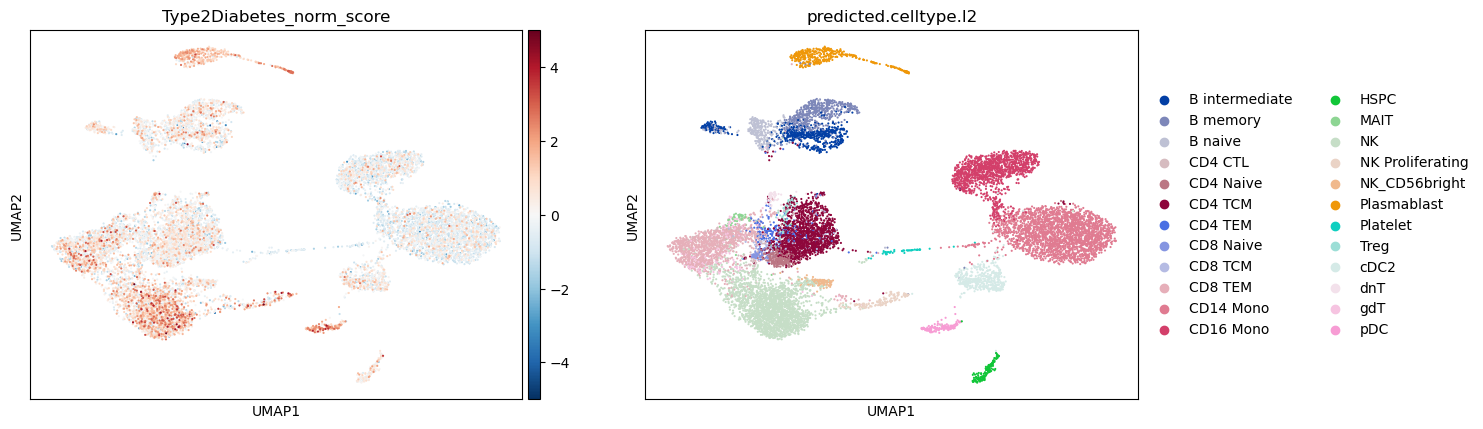

In [8]:
adata_scdrs = run_scdrs(
    dd.C,
    gene_sets=gene_sets,
    n_ctrl=1000,
    return_adata=True,
)

sc.pp.neighbors(adata_scdrs)
sc.tl.umap(adata_scdrs)

sc.pl.umap(
    adata_scdrs,
    color=["Type2Diabetes_norm_score", "predicted.celltype.l2"],
    cmap="RdBu_r",
    vmin=-5,
    vmax=5,
)

Found 612 significantly associated cells (p < 0.05)


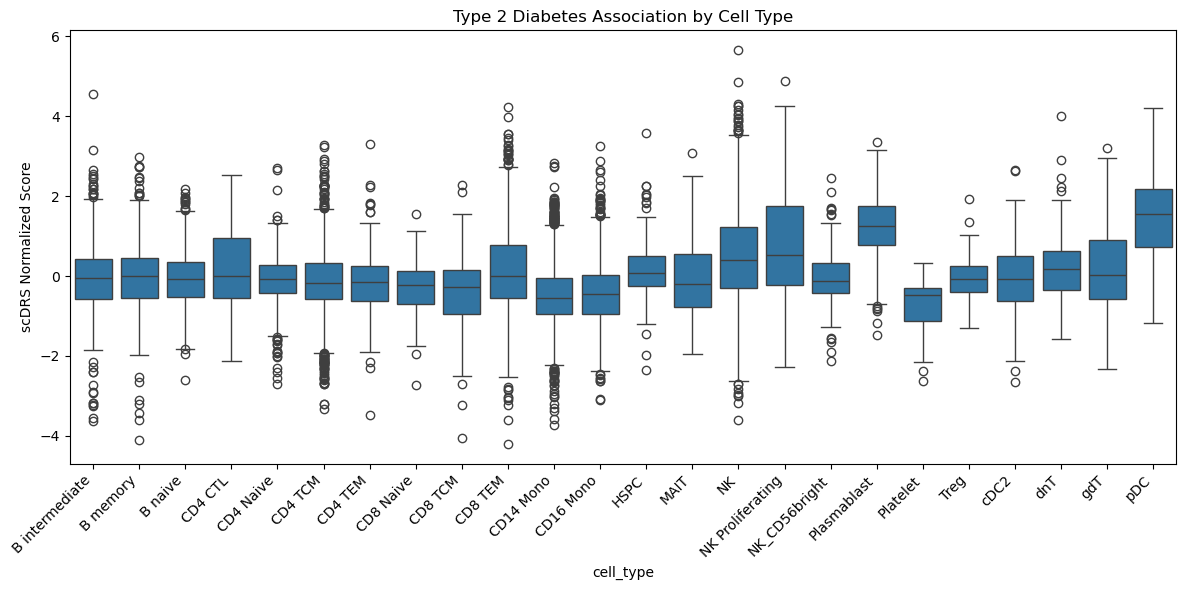

In [9]:
sig_cells = score_df[score_df["pval"] < 0.05]
print(f"Found {len(sig_cells)} significantly associated cells (p < 0.05)")

cell_type_scores = pd.DataFrame({
    "cell_type": adata_scdrs.obs["predicted.celltype.l2"],
    "disease_score": adata_scdrs.obs["Type2Diabetes_norm_score"]
})

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=cell_type_scores,
    x="cell_type",
    y="disease_score",
    ax=ax
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("scDRS Normalized Score")
plt.title("Type 2 Diabetes Association by Cell Type")
plt.tight_layout()
plt.savefig("scdrs_celltype_boxplot.png", dpi=300)

## Part 2: Seismic Analysis - Cell Type-Trait Associations
Seismic identifies which cell types are most relevant to a trait and finds the genes driving these associations.
### Running Seismic

In [10]:
associations = run_seismic(
    dd.C, 
    magma_file="trait.genes.out",  
    cell_type_col="predicted.celltype.l2",
    species="human",
    top_n_associations=20,
    prefix="t2d_seismic",
    plot_associations=True,
)

print("Top cell type-trait associations:")
print(associations.sort_values("pvalue").head(10)[
    ['cell_type', 'pvalue', 'FDR']
])

sig_celltypes = associations[associations['FDR'] < 0.05]
print(f"\nSignificant cell types (FDR < 0.05): {len(sig_celltypes)}")

[2026-01-14 19:16:33,480] INFO:cellink.tl.external._seismic: Preparing data for seismic analysis
[2026-01-14 19:16:33,481] INFO:cellink.tl.external._seismic: Filtering cells and genes
[2026-01-14 19:16:33,560] INFO:cellink.tl.external._seismic: Exporting data for R
[2026-01-14 19:16:57,676] INFO:cellink.tl.external._seismic: Saved expression matrix: t2d_seismic_expression.csv.gz
[2026-01-14 19:16:57,701] INFO:cellink.tl.external._seismic: Saved cell metadata: t2d_seismic_metadata.csv
[2026-01-14 19:16:57,709] INFO:cellink.tl.external._seismic: Created R script: t2d_seismic_seismic.R
[2026-01-14 19:16:57,710] INFO:cellink.tl.external._seismic: Running seismic analysis in R...
[2026-01-14 19:17:15,881] INFO:cellink.tl.external._seismic: Loading expression data...
Creating SingleCellExperiment...
Calculating cell type specificity...
Translating gene IDs...
Loading MAGMA results...
Computing cell type-trait associations...
Saved associations to t2d_seismic_associations.tsv
null device 
   

## Part 3: Comparing Methods

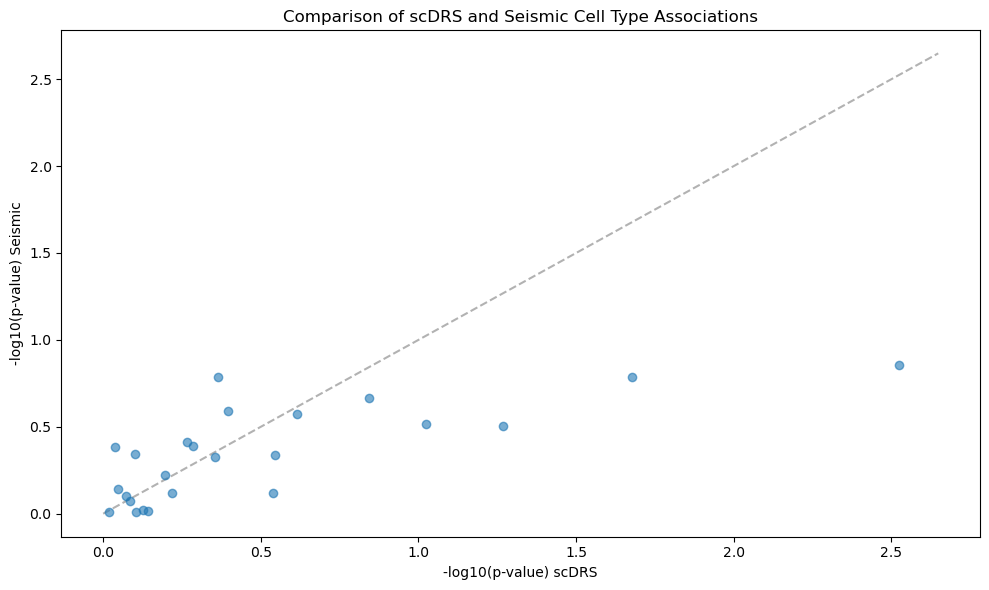

In [11]:
scdrs_ct = ct_results.copy()
scdrs_ct["method"] = "scDRS"
scdrs_ct["log_pval"] = -np.log10(scdrs_ct["assoc_mcp"])

seismic_ct = associations.copy()
seismic_ct["method"] = "Seismic"
seismic_ct["log_pval"] = -np.log10(seismic_ct["pvalue"])

fig, ax = plt.subplots(figsize=(10, 6))

comparison = pd.merge(
    scdrs_ct[["log_pval"]],
    seismic_ct[["cell_type", "log_pval"]],
    left_index=True,
    right_on="cell_type",
    suffixes=("_scDRS", "_Seismic")
)

ax.scatter(
    comparison["log_pval_scDRS"],
    comparison["log_pval_Seismic"],
    alpha=0.6
)
ax.set_xlabel("-log10(p-value) scDRS")
ax.set_ylabel("-log10(p-value) Seismic")
ax.set_title("Comparison of scDRS and Seismic Cell Type Associations")

lims = [0, max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, 'k--', alpha=0.3, zorder=0)

plt.tight_layout()
plt.savefig("scdrs_seismic_comparison.png", dpi=300)